# **Data Cleaning**

## *Table of Contents*

1. [**Data Cleaning**](./01_Data_Cleaning.ipynb)
   1. [*Library Imports*](#Library-Imports)
   2. [*File Importation*](#File-Importation)
   3. [*Pre-Cleaned Data Inspection*](#Pre-Cleaned-Data-Inspection)
   4. [*Data Preparation / Cleaning for Model Fitting*](#Data-Preparation--Cleaning-for-Model-Fitting)
   5. [*Post-Cleaning Data Inspection*](#Post-Cleaning-Data-Inspection)
   6. [*'BuildingArea' Imputation*](#BuildingArea-Imputation)
   7. [*Post-Analysis of 'BuildingArea' Imputation*](#Post-Analysis-of-'BuildingArea'-Imputation)
   8. [*Export Data*](#Export-Data)
2. [EDA and Feature Engineering](../02_Exploratory_Data_Analysis/2_Exploratory_Data_Analysis.ipynb)

## **Library Imports**

### Standard library imports

In [30]:
import sys # Provides a way of using operating system dependent functionality
import os  # For interacting with the operating system
from datetime import datetime  # For handling date and time data

### Third-party imports

In [31]:
import matplotlib.pyplot as plt  # For creating visualizations
import missingno as msno  # For visualizing missing data
import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation and analysis
import seaborn as sns  # For high-level data visualization

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV, SelectKBest, mutual_info_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score, 
                                     StratifiedKFold, KFold)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

### Local application imports

In [32]:
# Define the absolute path of the parent directory of the script's grandparent directory
# This is useful for module importation from a different directory structure
parent_dir = os.path.dirname(os.getcwd())
sys.path.insert(0, parent_dir)

# Local application imports
from utils import plot_utils, func_utils

## **File Importation**

In [33]:
# Determine the absolute path to the directory containing the current script
script_dir = os.path.dirname(os.getcwd())

# Construct the path to the data file
data_path = os.path.join(script_dir, '00_Raw_Data', '0_melb_data.csv')

# Load the dataset, parsing dates to ensure proper datetime format
melb_data = pd.read_csv(data_path, parse_dates=['Date'], dayfirst=True)

C:\Users\AAA\AppData\Local\Temp\ipykernel_72164\3112342448.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  melb_data = pd.read_csv(data_path, parse_dates=['Date'], dayfirst=True)


### Date Extraction

In [34]:
# Data manipulation: extracting year and month from the date for further analysis
melb_data['Year'] = melb_data['Date'].dt.year
melb_data['Month'] = melb_data['Date'].dt.month
melb_data['Date'] = melb_data['Date'].dt.date  # Simplify 'Date' to date format

### Drop Duplicates

In [35]:
# Remove duplicate entries to maintain data integrity
melb_data.drop_duplicates(inplace=True)

## **Pre-Cleaned Data Inspection**

              Rooms         Price      Distance      Postcode      Bedroom2  \
count  13580.000000  1.358000e+04  13580.000000  13580.000000  13580.000000   
mean       2.937997  1.075684e+06     10.137776   3105.301915      2.914728   
std        0.955748  6.393107e+05      5.868725     90.676964      0.965921   
min        1.000000  8.500000e+04      0.000000   3000.000000      0.000000   
25%        2.000000  6.500000e+05      6.100000   3044.000000      2.000000   
50%        3.000000  9.030000e+05      9.200000   3084.000000      3.000000   
75%        3.000000  1.330000e+06     13.000000   3148.000000      3.000000   
max       10.000000  9.000000e+06     48.100000   3977.000000     20.000000   

           Bathroom           Car       Landsize  BuildingArea    YearBuilt  \
count  13580.000000  13518.000000   13580.000000   7130.000000  8205.000000   
mean       1.534242      1.610075     558.416127    151.967650  1964.684217   
std        0.691712      0.962634    3990.669241   

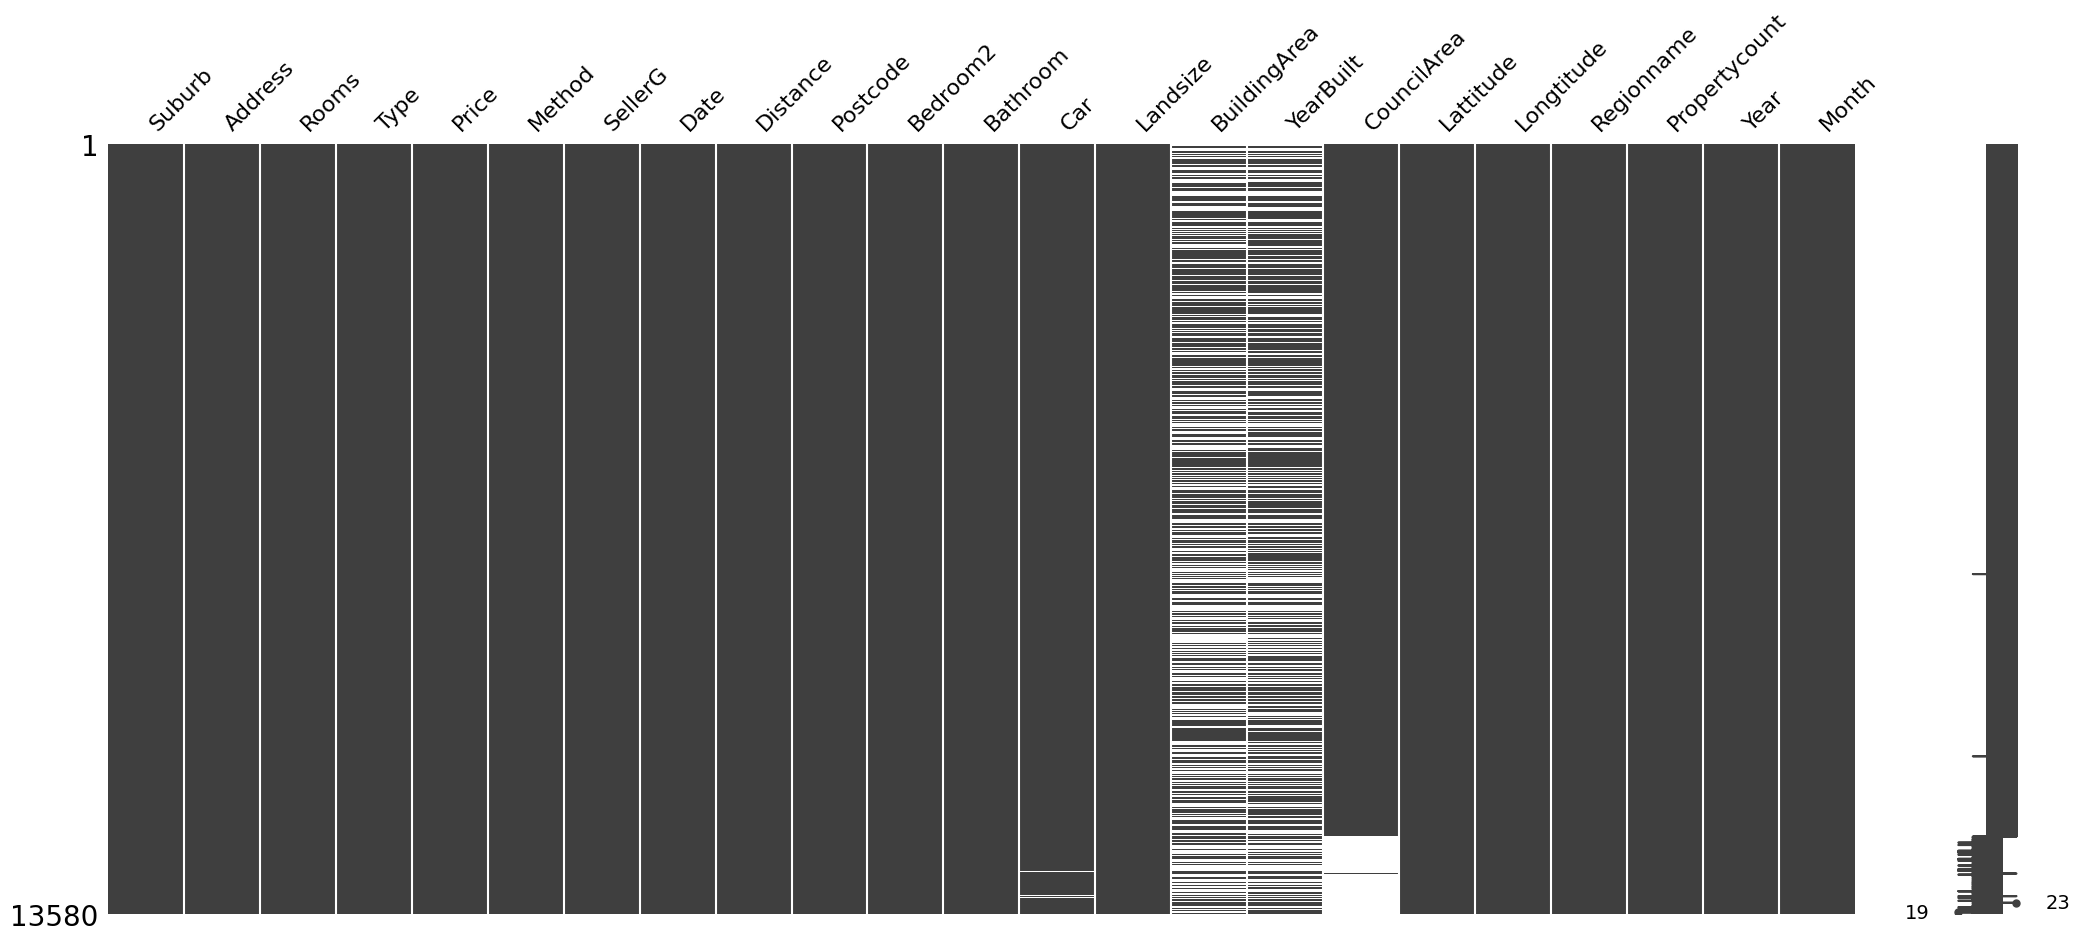

In [36]:
# Display summary statistics for the dataset
print(melb_data.describe())

# Identify missing values across columns
print('\n Missing values across columns:')
print(melb_data.isna().sum())

# Identify number of entries in dataset
print(f'\n Number of entries in dataset: {melb_data.shape[0]}')

# Visualize missing data to guide cleaning and imputation strategies
msno.matrix(melb_data)
plt.show()

## **Data Preparation / Cleaning for Model Fitting**

### Indicator Variable Creation

In [37]:
# Create binary indicators for specific conditions to enhance model interpretation
melb_data['Bathroom_was_0'] = np.where(melb_data['Bathroom'] == 0, True, False)
melb_data['Car_was_missing'] = melb_data['Car'].isna()
melb_data['Landsize_Indicator'] = np.where(melb_data['Landsize'] == 0, 1, 0)
melb_data['BuildingArea_was_missing'] = melb_data['BuildingArea'].isna()

###  Resolving Missing Values and Errors

In [38]:
# Replace 0 bathroom counts with the median number of bathrooms.
melb_data['Bathroom'] = np.where(melb_data['Bathroom'] == 0, melb_data['Bathroom'].median(), melb_data['Bathroom'])

# Fill missing values in 'Car' column with the median number of cars.
melb_data.fillna(value={'Car': melb_data['Car'].median()}, inplace=True)

In [39]:
# Define a function to determine the effective number of bedrooms
# based on 'Rooms' and 'Bedroom2' columns
def effective_bedrooms(row):
    """
    Calculate the effective number of bedrooms for a property.
    
    This function takes into account discrepancies between 'Rooms' and 
    'Bedroom2' columns. It applies logic to decide the most representative 
    value for the number of bedrooms.

    Parameters:
    row (pd.Series): A row of the DataFrame.

    Returns:
    int: The calculated effective number of bedrooms.
    """
    if row['Rooms'] > row['Bedroom2'] and row['Bedroom2'] != 0:
        return row['Bedroom2']
    elif row['Rooms'] < row['Bedroom2'] and row['Rooms'] != 0:
        return row['Rooms']
    elif row['Rooms'] == row['Bedroom2']:
        return row['Rooms']
    else:
        return row['Rooms'] + row['Bedroom2']

# Apply the effective_bedrooms function to the dataset
melb_data['NewBed'] = melb_data.apply(effective_bedrooms, axis=1)

In [40]:
def fill_councilarea(row):
    """
    Fill missing 'CouncilArea' based on properties in the same suburb.

    This function matches properties by 'Suburb', 'Postcode', 'Regionname', 
    and 'Propertycount' to fill missing 'CouncilArea' values. If a matching 
    property with a non-null 'CouncilArea' is found, its 'CouncilArea' value 
    is used.

    Parameters:
    row (pd.Series): A row from the DataFrame.

    Returns:
    str: The filled or original 'CouncilArea' value for the row.
    """
    if pd.isnull(row['CouncilArea']):
        match = melb_data[(row['Suburb'] == melb_data['Suburb']) & 
                          (row['Postcode'] == melb_data['Postcode']) & 
                          (row['Regionname'] == melb_data['Regionname']) & 
                          (row['Propertycount'] == melb_data['Propertycount']) & 
                          pd.notnull(melb_data['CouncilArea'])]
        if not match.empty:
            return match.iloc[0]['CouncilArea']
    return row['CouncilArea']

melb_data['CouncilArea'] = melb_data.apply(fill_councilarea, axis=1)

### DataFrame Refinement

In [41]:
# Simplify the dataset by dropping columns not needed for further analysis
melb_data.drop(columns=['Rooms', 'Bedroom2', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount'], inplace=True)

# Reorder columns for readability and analysis purposes
melb_data = melb_data[[
    'Address', 'Postcode', 'Suburb', 'Regionname', 'CouncilArea', 'Type', 
    'Price', 'SellerG', 'Method', 'Date', 'Year', 'Month', 'NewBed', 
    'Bathroom', 'Bathroom_was_0', 'Car', 'Car_was_missing', 'Distance',
    'Landsize', 'Landsize_Indicator', 'BuildingArea'
]]

## **Post-Cleaning Data Inspection**

           Postcode         Price          Year         Month        NewBed  \
count  13580.000000  1.358000e+04  13580.000000  13580.000000  13580.000000   
mean    3105.301915  1.075684e+06   2016.533432      7.052283      2.899853   
std       90.676964  6.393107e+05      0.498899      2.536034      0.942558   
min     3000.000000  8.500000e+04   2016.000000      1.000000      1.000000   
25%     3044.000000  6.500000e+05   2016.000000      5.000000      2.000000   
50%     3084.000000  9.030000e+05   2017.000000      7.000000      3.000000   
75%     3148.000000  1.330000e+06   2017.000000      9.000000      3.000000   
max     3977.000000  9.000000e+06   2017.000000     12.000000     10.000000   

           Bathroom           Car      Distance       Landsize  \
count  13580.000000  13580.000000  13580.000000   13580.000000   
mean       1.536745      1.611856     10.137776     558.416127   
std        0.687953      0.960793      5.868725    3990.669241   
min        1.000000     

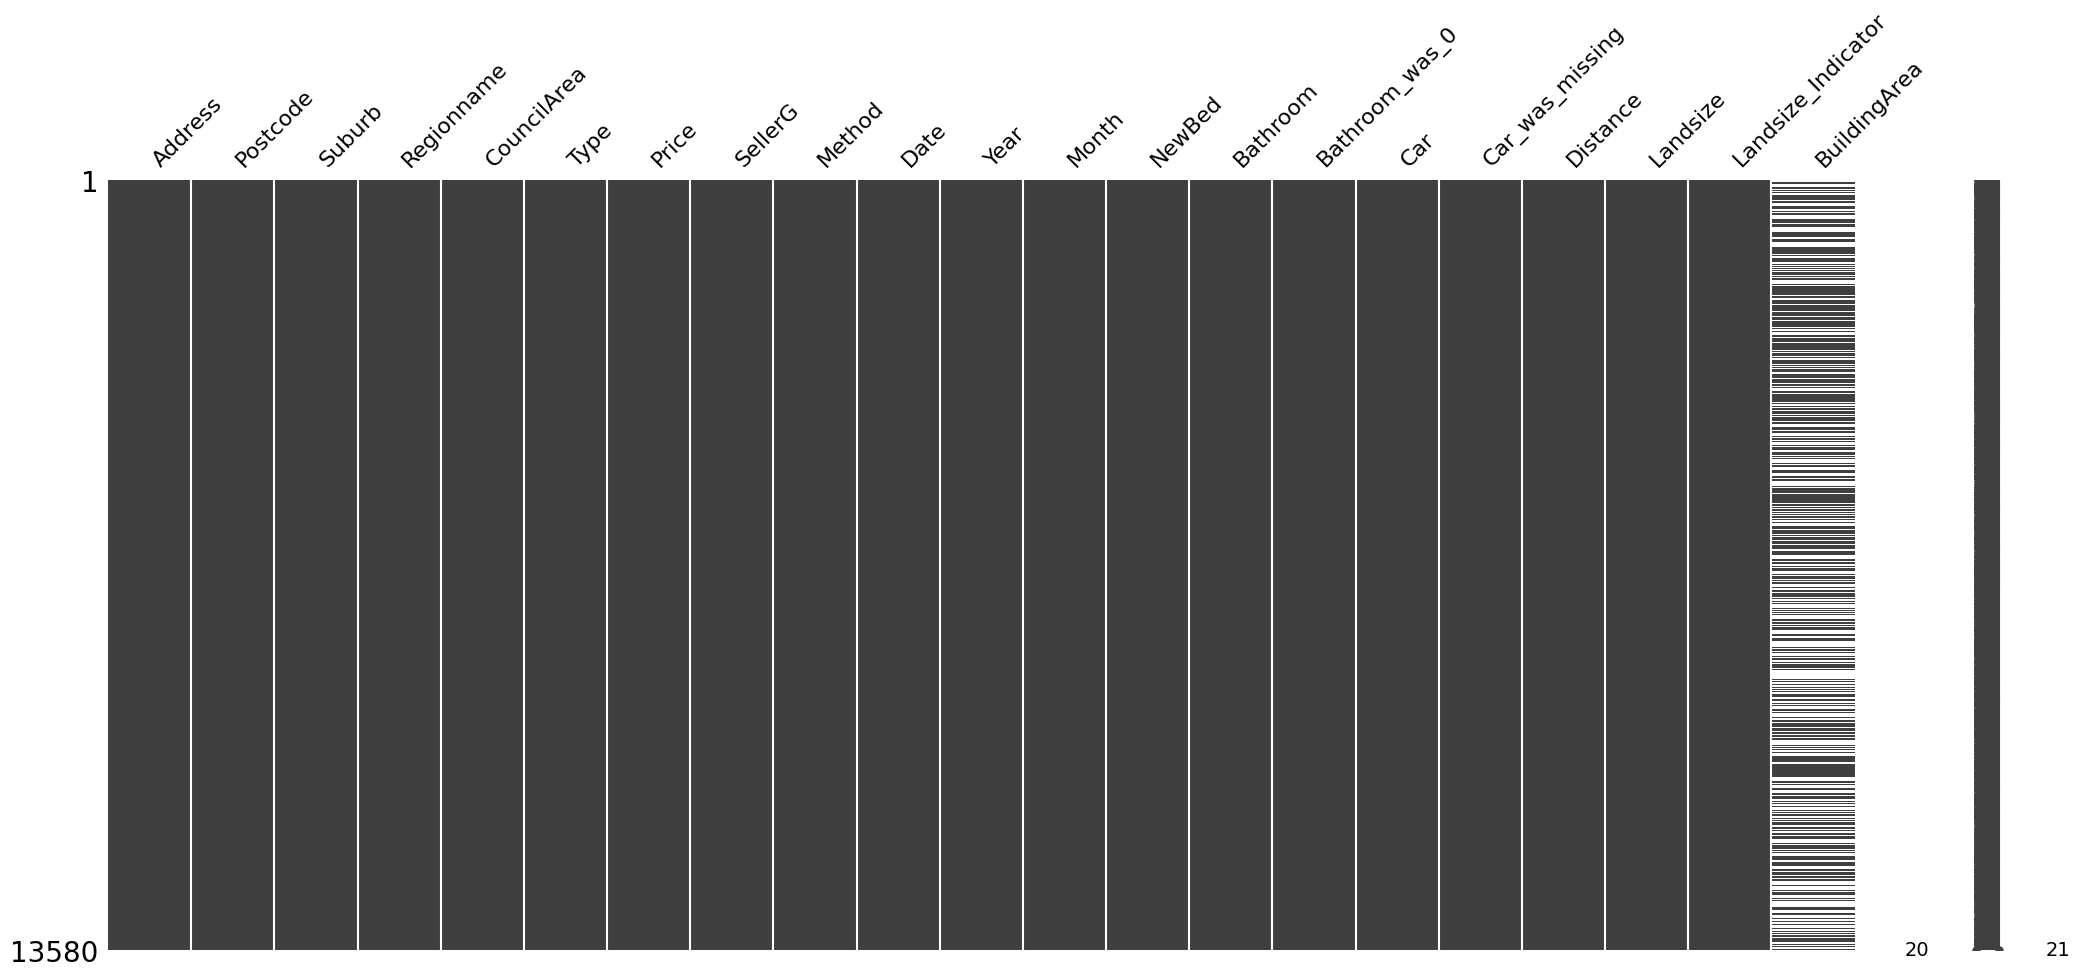

In [42]:
# Summarize the cleaned dataset to verify changes
print(melb_data.describe())

# Check for remaining missing values post-cleaning
print('\n Post-cleaning missing values across columns:')
print(melb_data.isna().sum())

# Visualize the cleaned data to ensure readiness for analysis
msno.matrix(melb_data)
plt.show()

### Handling Outliers

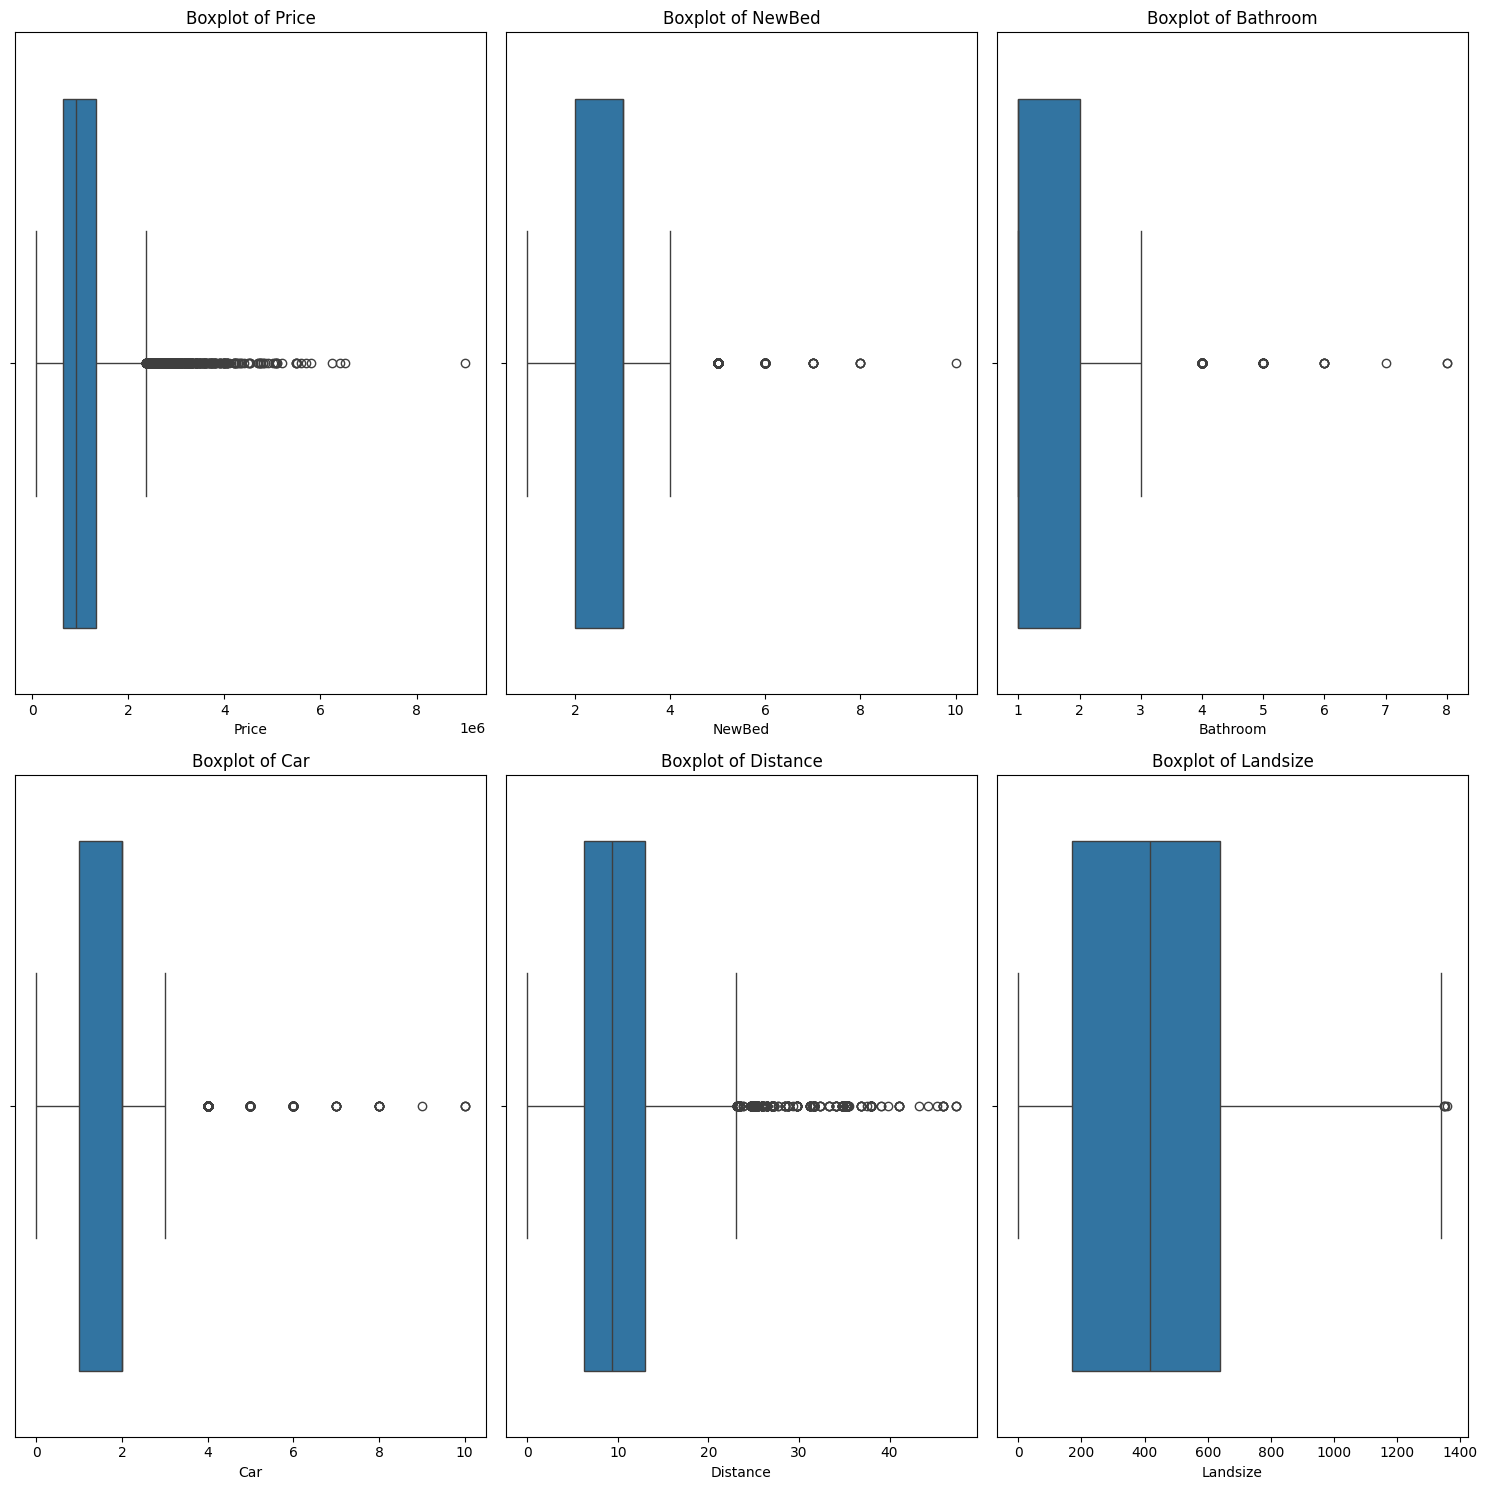

In [57]:
# Outlier handling: Identify and mitigate outliers in key quantitative columns
quan_columns = ['Price', 'NewBed', 'Bathroom', 'Car', 'Distance', 'Landsize']
plot_utils.plot_box(data=melb_data, column_list=quan_columns, rows=2, cols=3) # Utilize utility for boxplot visualization

In [44]:
# Identify and handle outliers for 'Landsize' column
q1, q3 = melb_data['Landsize'].quantile([0.25, 0.75])
IQR = q3 - q1
upper, lower = q3 + (1.5 * IQR), q1 - (1.5 * IQR)
melb_data = melb_data[(melb_data['Landsize'] >= lower) & (melb_data['Landsize'] <= upper)].copy()

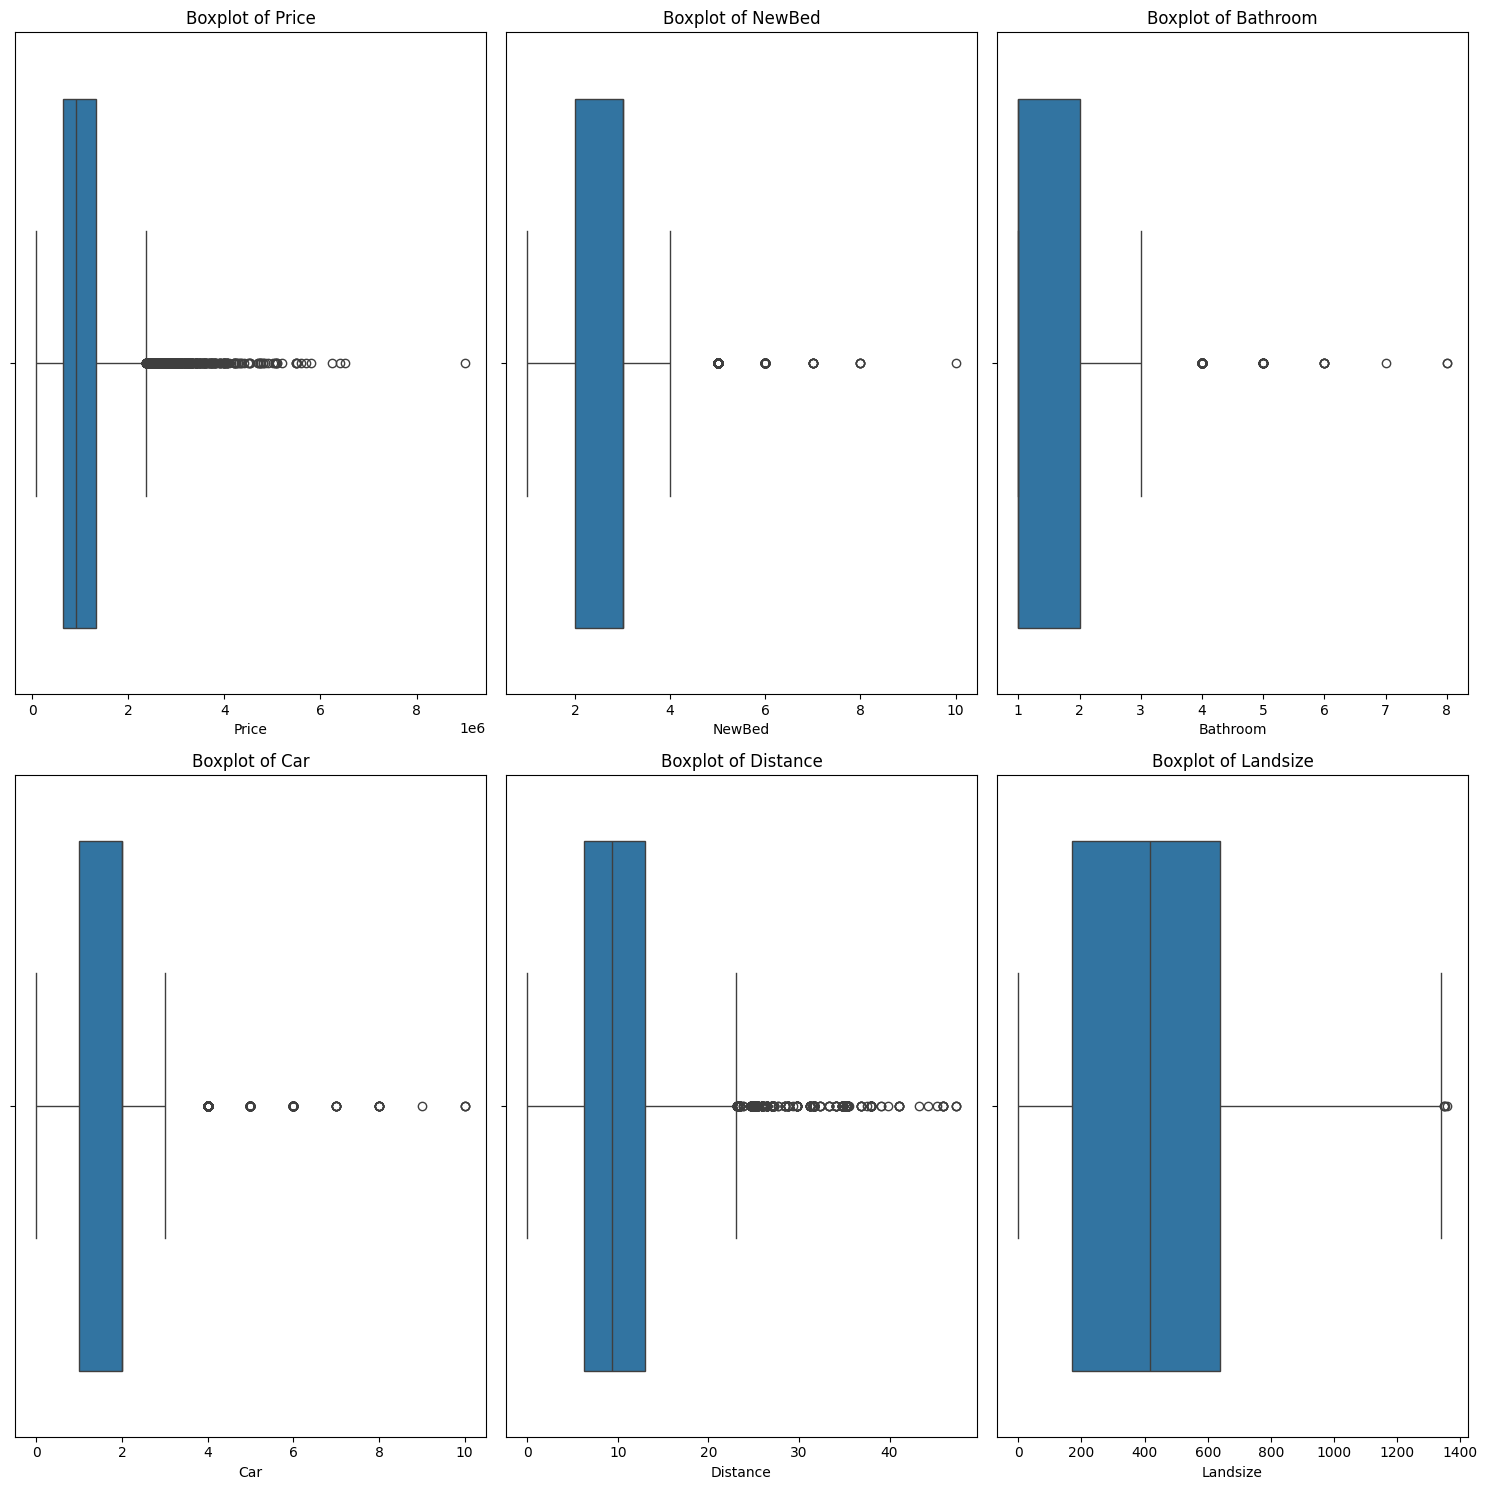


 Number of entries in dataset: 13212


In [45]:
# Re-visualize post-outlier adjustment to verify correction
plot_utils.plot_box(data=melb_data, column_list=quan_columns, rows=2, cols=3)
plt.show()

# Identify number of entries in dataset
print(f'\n Number of entries in dataset: {melb_data.shape[0]}')

## **'BuildingArea' Imputation**

### Preliminary Analysis

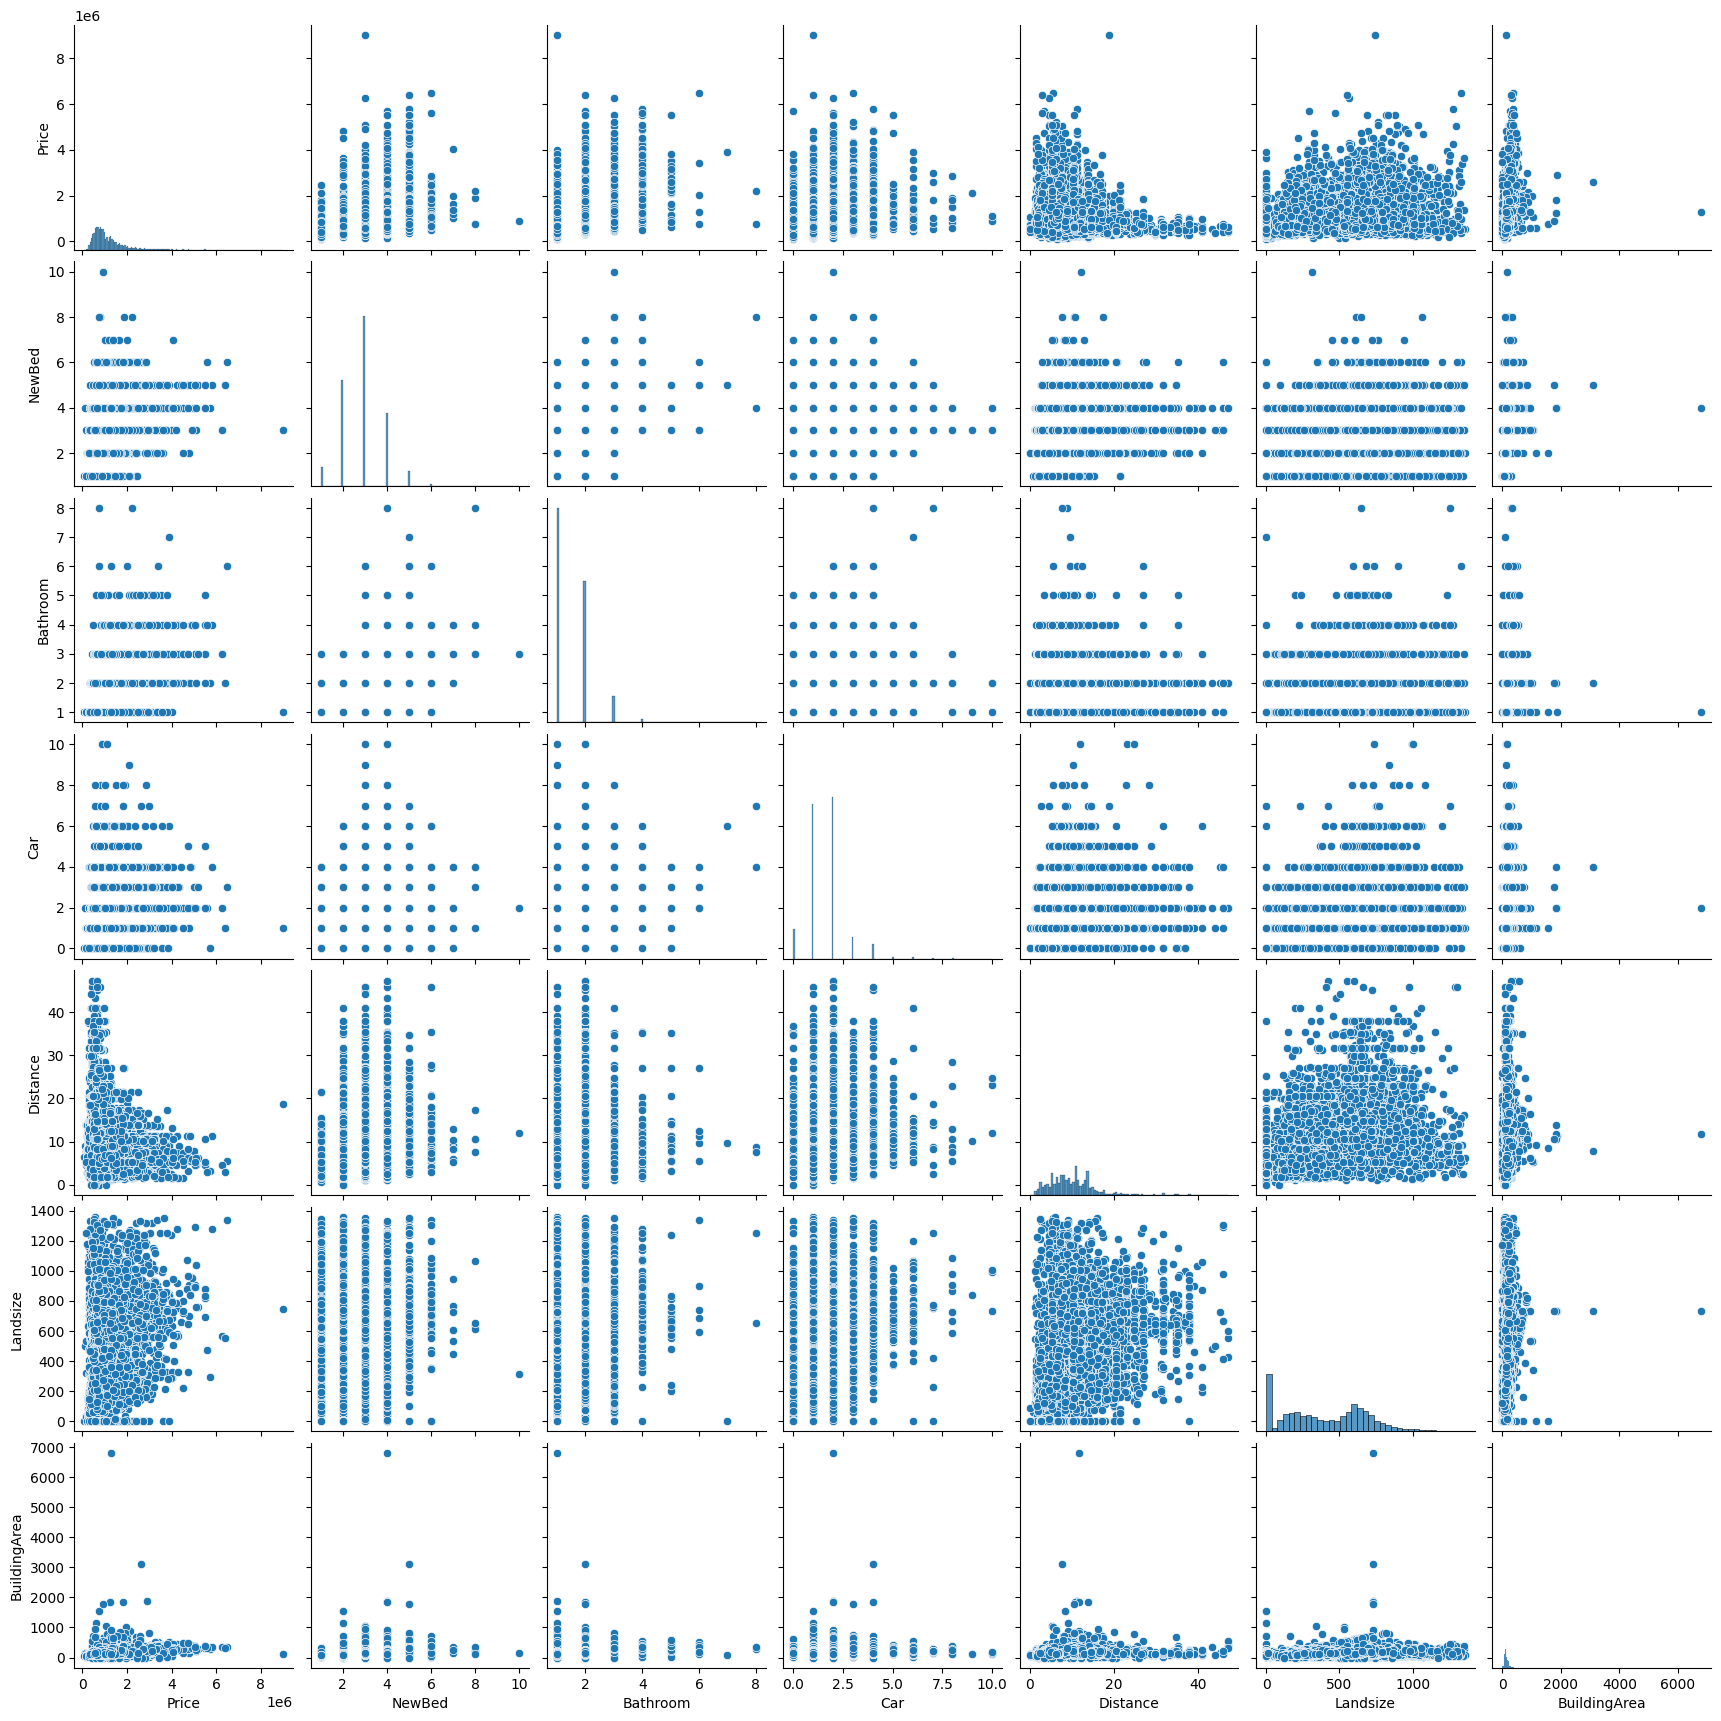

In [62]:
# Explore the relationships between quantitative variables and visualize correlations.
sns.pairplot(data=melb_data[quan_columns + ['BuildingArea']])
plt.show()

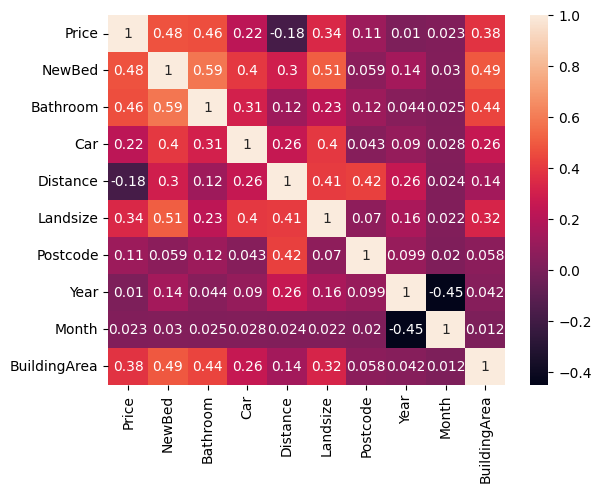

In [58]:
# Extend the list of quantitative columns with additional relevant features
quan_columns_ex = quan_columns + ['Postcode', 'Year', 'Month', 'BuildingArea']

# Calculate the correlation matrix for the specified quantitative columns
corr_test = melb_data[quan_columns_ex].corr()

# Visualize the correlation matrix using a heatmap
sns.heatmap(corr_test, annot=True)
plt.show()


### Feature Selection

#### Preparation for Feature Selection

#### Mutual Information (MI)

#### Recursive Feature Elimination (RFE)

**Initialize Your Estimator**:
Choose the model you want to use for feature selection and eventual prediction. Here, I'll use `RandomForestRegressor` as an example.

**Apply RFECV**:
Now, apply `RFECV` to your data. You can specify the cross-validation strategy (e.g., K-fold) and the scoring metric you want to use.

*note*: model took 59m 38.5s

*note*: we switched from `cv_strategy = StratifiedKFold(n_splits=5)` to `cv_strategy = KFold(n_splits=3, shuffle=True, random_state=42)` because `StratifiedKFold` is designed for classification tasks where the target variable is categorical (either binary or multiclass). For regression tasks, you should use `KFold` or another cross-validation generator that does not require the target to be categorical. 

**Review the Results**:
After fitting `RFECV` to your data, you can examine which features were selected and the optimal number of features.

Optimal number of features:  4

Best features:  Index(['NewBed', 'Bathroom', 'Distance', 'Landsize'], dtype='object')

**Plot the CV Score vs. Number of Features**:
This helps visualize the performance of the model as you vary the number of features.

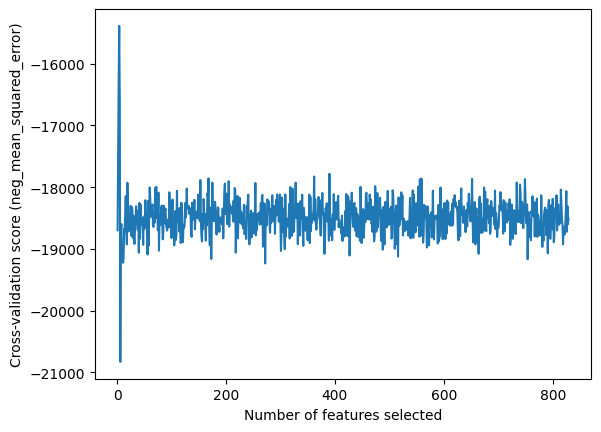

### Preprocessing for Model Training

In [48]:
# Prepare the data for model training by selecting predictive features.
predictive_features = ['NewBed', 'Bathroom', 'Distance', 'Landsize']
target = 'BuildingArea'

X = melb_data.dropna(subset=[target])[predictive_features]
y = melb_data.dropna(subset=[target])[target]

# Define features for the preprocessor.
# categorical_features = ['Postcode', 'Suburb', 'Regionname', 'CouncilArea', 'Type', 'SellerG', 'Method','Year', 'Month']
numeric_features = ['NewBed', 'Bathroom', 'Distance', 'Landsize']

# Create a preprocessor for features.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features) # ,('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Split the data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### GridSearchCV for Random Forest

### Random Forest Model Fitting

In [49]:
# Refit the pipeline with the best parameters found from GridSearchCV.
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=18,
        random_state=42))
])
rf_pipeline.fit(X_train, y_train)

# Predict on training and test data.
y_train_pred = rf_pipeline.predict(X_train)
y_test_pred = rf_pipeline.predict(X_test)

### Model Diagnostics

#### Cross Validation

In [50]:
# Perform 5-fold cross-validation to evaluate the model.
cv_scores = cross_val_score(rf_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
cv_scores = -cv_scores  # Convert scores to positive

# Print cross-validation scores, mean, and standard deviation.
print(f"CV MSE scores: {cv_scores}")
print(f"CV MSE mean: {cv_scores.mean()}")
print(f"CV MSE standard deviation: {cv_scores.std()}")

CV MSE scores: [43312.69290626  5036.06946766  3688.83410456  4746.96774413
  6563.6131411 ]
CV MSE mean: 12669.635472742346
CV MSE standard deviation: 15349.105932886323


#### RMSE Calculation

In [51]:
# Calculate RMSE for both training and test datasets.
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Training RMSE: 95.17696707865854
Test RMSE: 70.2950467540274


#### MSE & MAE Calculation

In [52]:
# Calculate MSE and MAE for both training and test datasets.
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"\nTraining MAE: {train_mae}")
print(f"Test MAE: {test_mae}")

Training MSE: 9058.655062292051
Test MSE: 4941.3935981508985

Training MAE: 31.14777398090432
Test MAE: 35.405199028636446


#### Feature Importance Analysis

In [53]:
# Access the random forest model inside the pipeline
rf_model = rf_pipeline.named_steps['model']



# Combine with numeric feature names as they are not transformed in this case
final_feature_names = numeric_features #+ ohe_columns

# Assuming rf_model is your RandomForestRegressor accessed from the pipeline
feature_importances = pd.Series(rf_model.feature_importances_, index=final_feature_names).sort_values(ascending=False)

print(feature_importances)

# Access the RandomForestRegressor model from the pipeline and print feature importances.
rf_model = rf_pipeline.named_steps['model']
'''
# Assuming your preprocessor is a ColumnTransformer named 'preprocessor' in the pipeline:
ohe_columns = list(rf_pipeline.named_steps['preprocessor']
                   .get_feature_names_out(input_features=categorical_features))
'''
final_feature_names = numeric_features #+ ohe_columns # Combine with numeric feature names
feature_importances = pd.Series(rf_model.feature_importances_, index=final_feature_names).sort_values(ascending=False)
print(feature_importances)

Landsize    0.444630
NewBed      0.393687
Bathroom    0.081994
Distance    0.079690
dtype: float64
Landsize    0.444630
NewBed      0.393687
Bathroom    0.081994
Distance    0.079690
dtype: float64


### Imputing Missing 'BuildingArea' using Predictive Model

In [54]:
# Predict 'BuildingArea' for rows where it is missing and impute these values.
X_missing = melb_data[melb_data[target].isnull()][predictive_features]
predicted_values = rf_pipeline.predict(X_missing)
rounded_pv = np.round_(predicted_values, decimals=0)

# Impute the predicted 'BuildingArea' back into the original dataset.
melb_data.loc[melb_data[target].isnull(), target] = rounded_pv

## **Post-Analysis of 'BuildingArea' Imputation**

           Postcode         Price          Year         Month        NewBed  \
count  13212.000000  1.321200e+04  13212.000000  13212.000000  13212.000000   
mean    3104.830381  1.078860e+06   2016.528686      7.067136      2.912807   
std       89.826350  6.298518e+05      0.499195      2.534710      0.934116   
min     3000.000000  8.500000e+04   2016.000000      1.000000      1.000000   
25%     3044.000000  6.503750e+05   2016.000000      5.000000      2.000000   
50%     3084.000000  9.100000e+05   2017.000000      7.000000      3.000000   
75%     3148.000000  1.335000e+06   2017.000000      9.000000      3.000000   
max     3977.000000  9.000000e+06   2017.000000     12.000000     10.000000   

           Bathroom           Car      Distance     Landsize  \
count  13212.000000  13212.000000  13212.000000  13212.00000   
mean       1.536331      1.614214     10.174690    414.82970   
std        0.684924      0.957924      5.754263    288.13084   
min        1.000000      0.00000

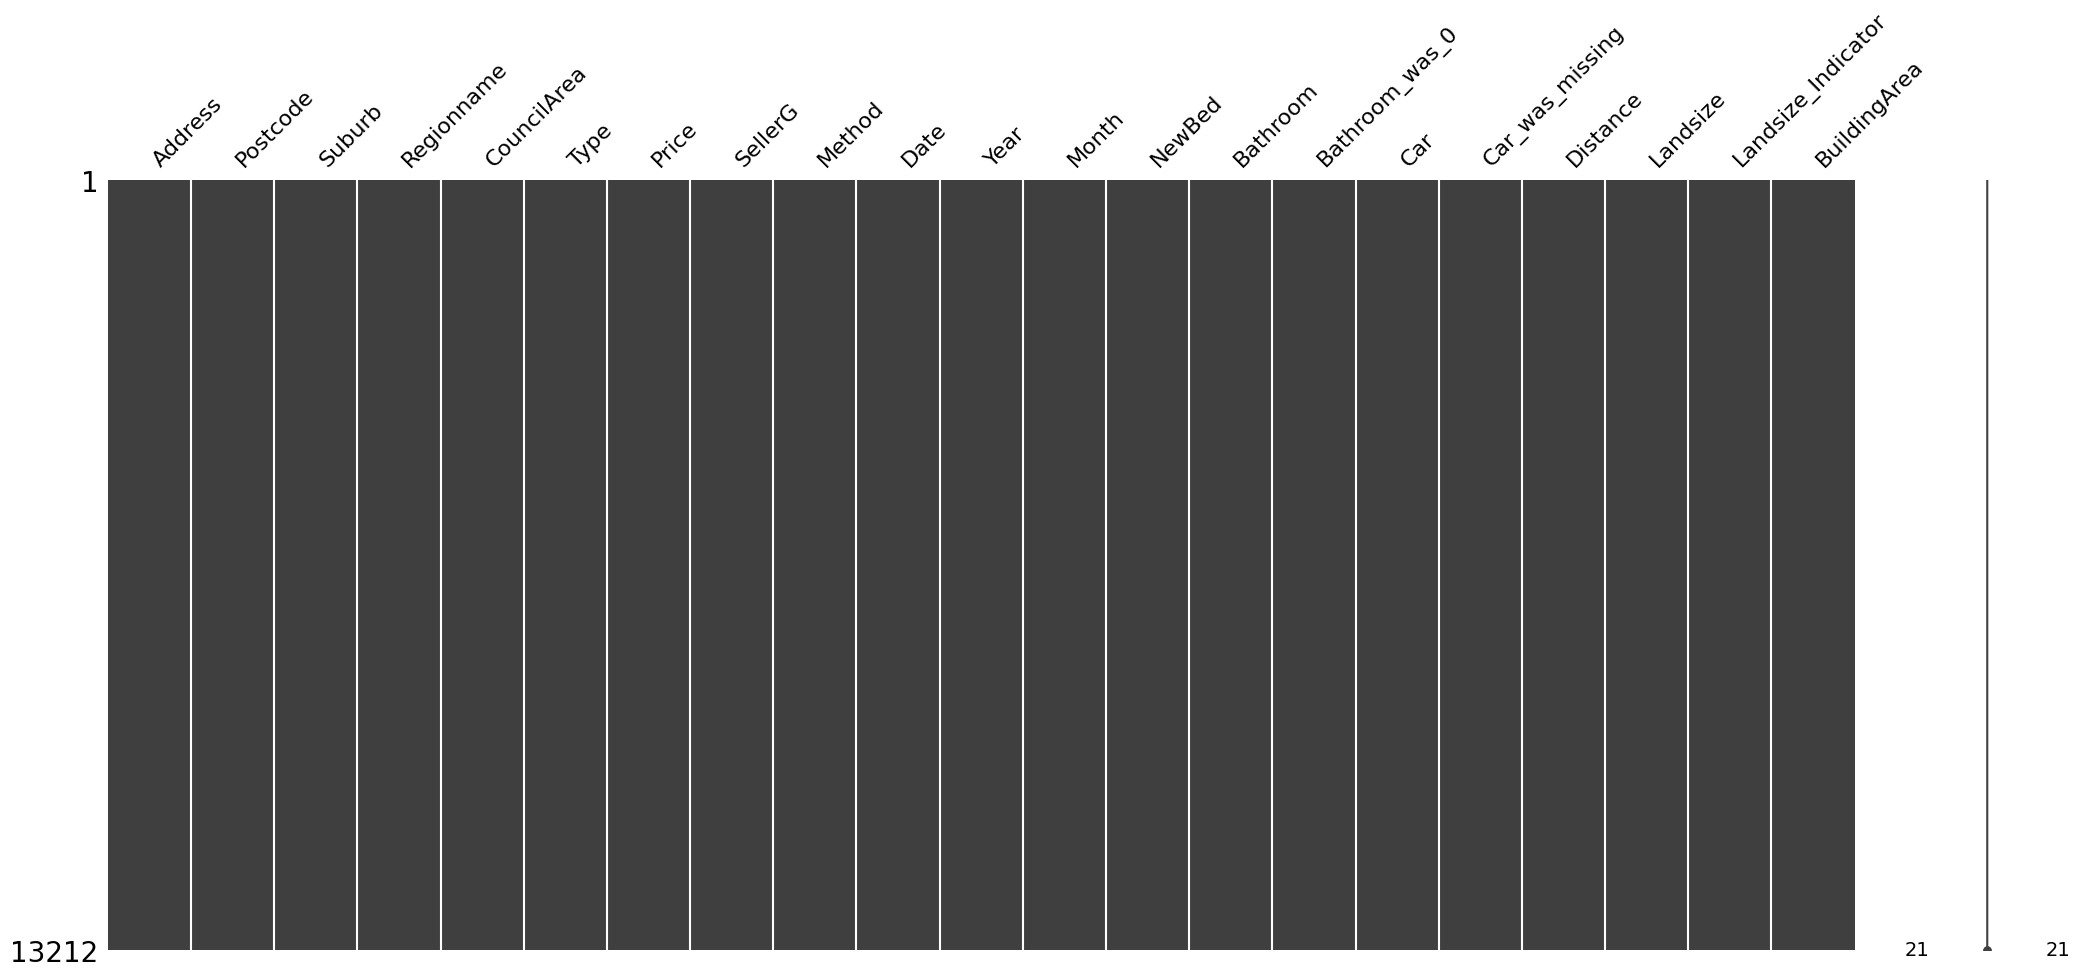

In [59]:
# Summarize the cleaned dataset to verify changes
print(melb_data.describe())

# Check for remaining missing values post-cleaning
print('\n Post-cleaning missing values across columns:')
print(melb_data.isna().sum())

# Visualize the cleaned data to ensure readiness for analysis
msno.matrix(melb_data)
plt.show()

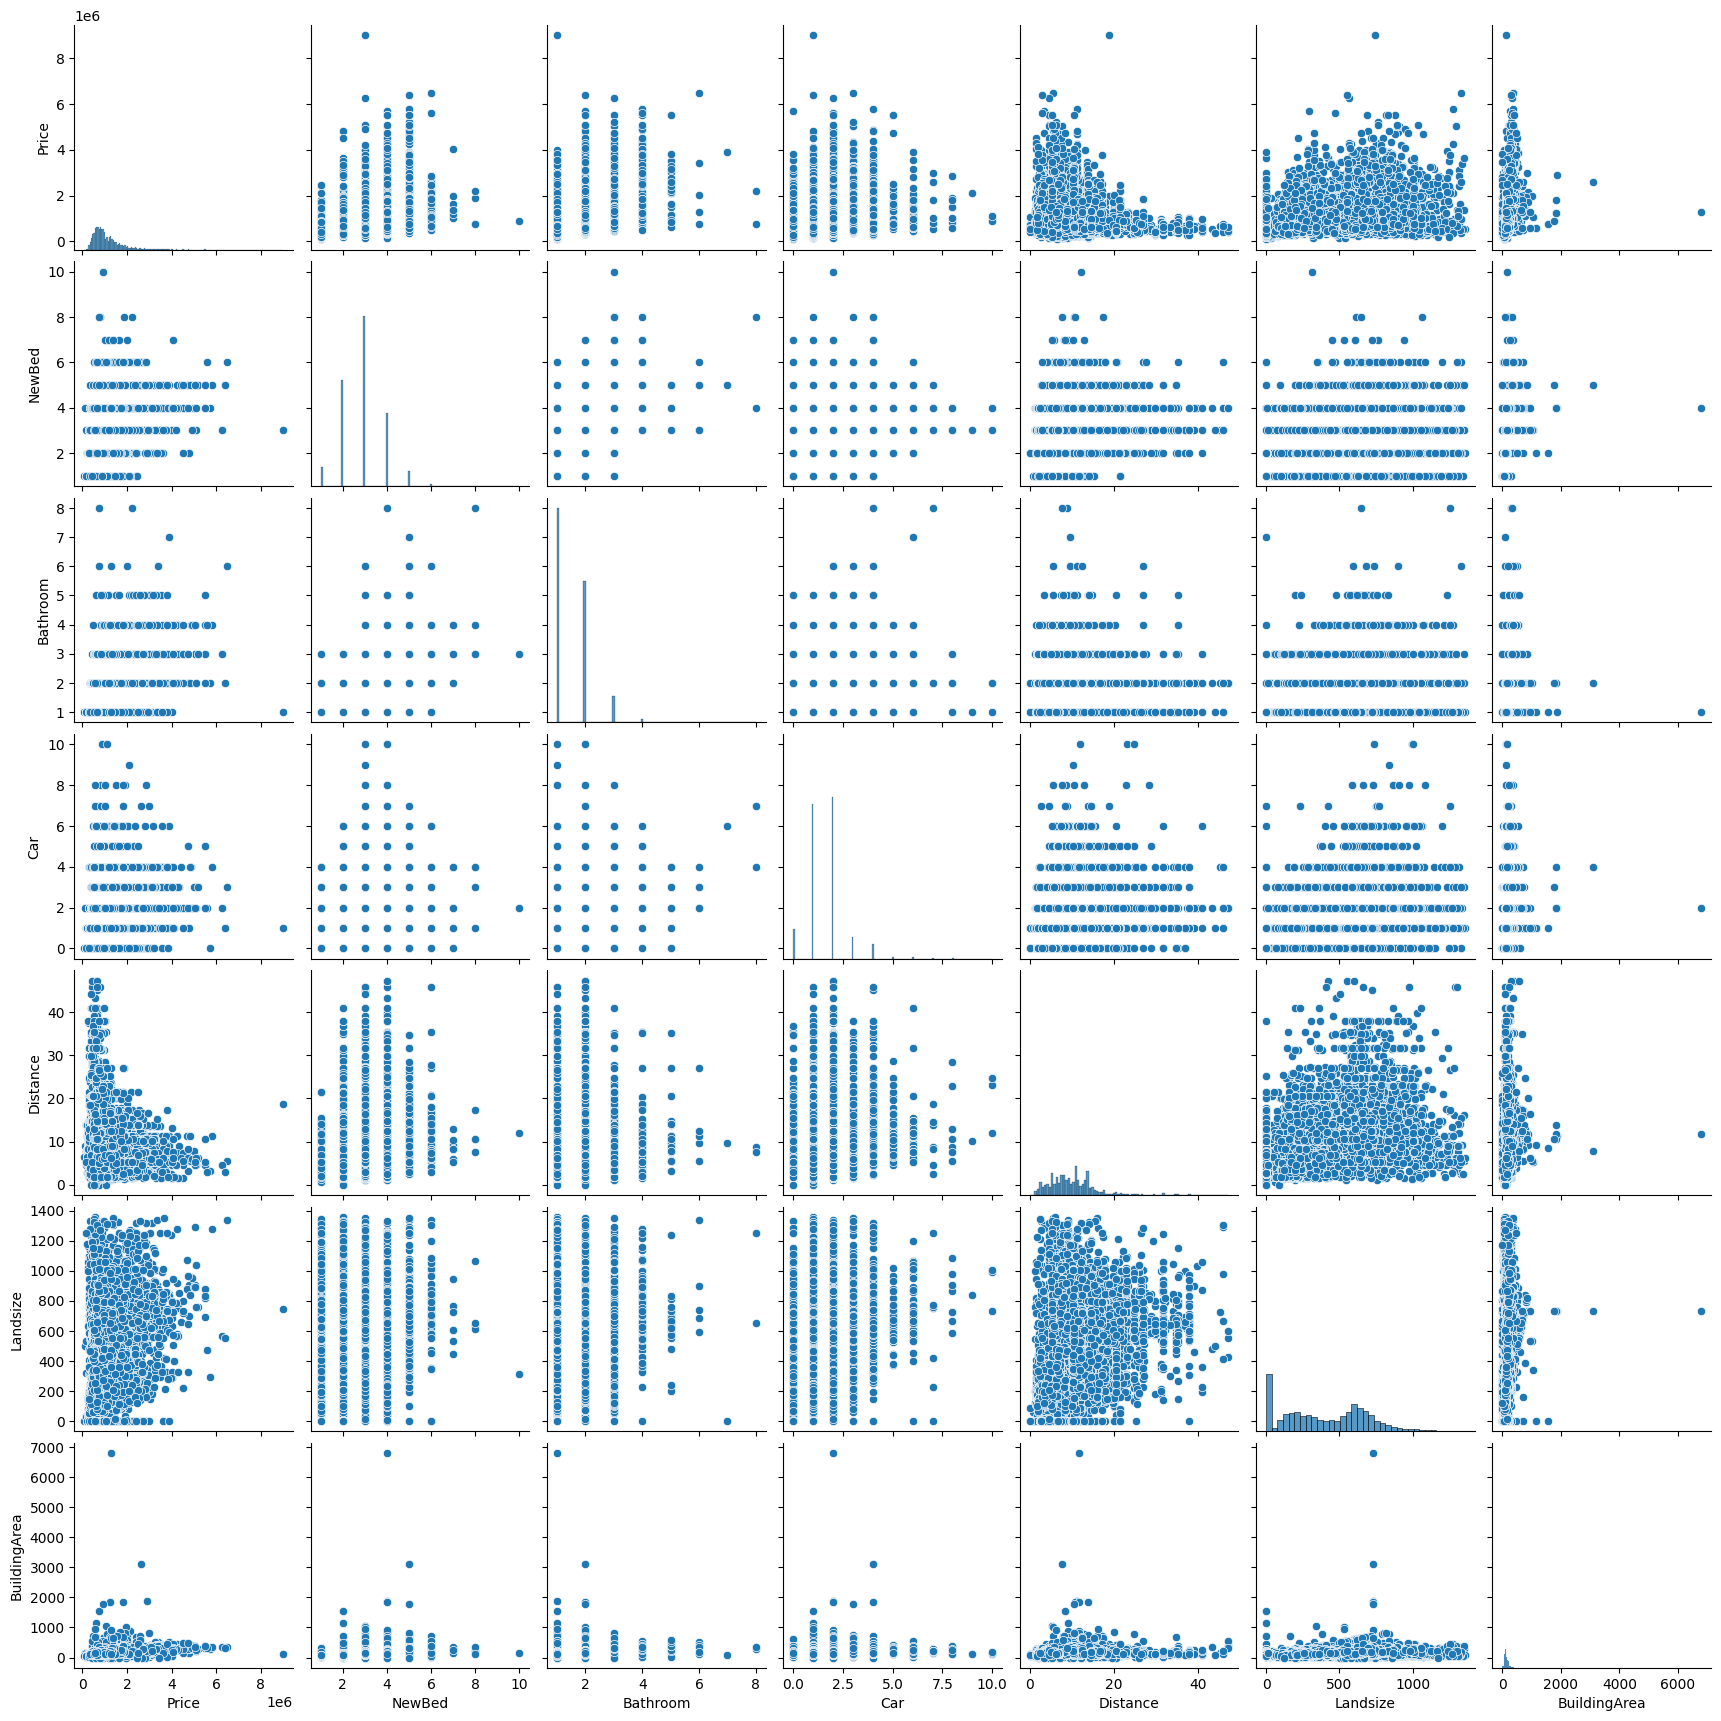

In [63]:
# Explore the relationships between quantitative variables and visualize correlations.
sns.pairplot(data=melb_data[quan_columns + ['BuildingArea']])
plt.show()

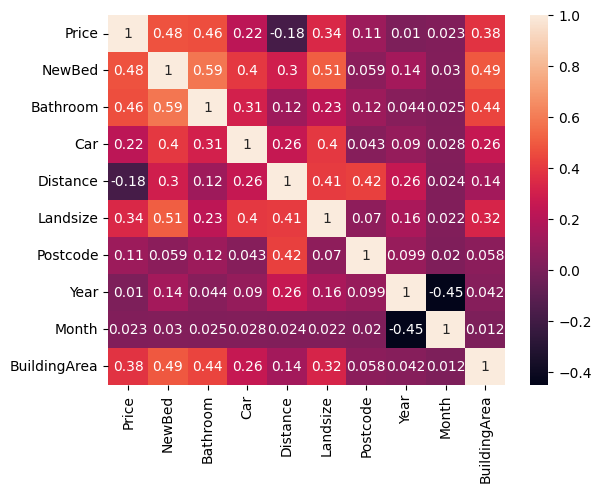

In [61]:
# Extend the list of quantitative columns with additional relevant features
quan_columns_ex = quan_columns + ['Postcode', 'Year', 'Month', 'BuildingArea']

# Calculate the correlation matrix for the specified quantitative columns
corr_test = melb_data[quan_columns_ex].corr()

# Visualize the correlation matrix using a heatmap
sns.heatmap(corr_test, annot=True)
plt.show()

## **Export Data**

In [55]:
# Construct the full file path
output_file_path = os.path.join(script_dir, '01_Data_Cleaning', '1_cleaned_melb_data.csv')

# Export the cleaned and processed data to a new CSV file
melb_data.to_csv(output_file_path, index=False)  # Export without the index